In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect = True)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp=calc_temps('2017-08-01','2017-08-07')
temp

[(72.0, 79.25, 83.0)]

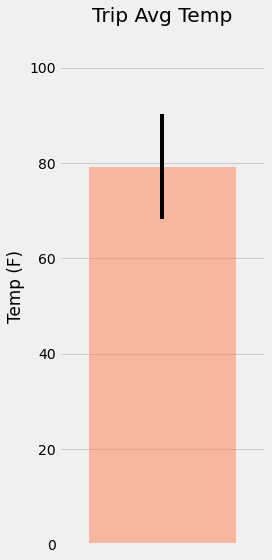

In [171]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tavg = 79.25
tmin = 72.0
tmax = 83.0
yerr = tmax-tmin 
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
ax.bar(1, tavg , yerr=yerr,alpha=0.5, color="coral", align = 'center')
ax.set(xticks=range(1), title="Trip Avg Temp", ylabel = ("Temp (F)"))
plt.savefig('Images/calc_temps.png', bbox_inches='tight',dpi = 150)
plt.margins(.2,.2)
plt.tight_layout()

In [27]:
print(ax.get_xticklabels())


[Text(0, 0, '0')]


### Daily Rainfall Average

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):

    sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
    return session.query(*sel).\
            filter(Measurement.station==Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()
print(precipitation('2017-08-01','2017-08-07'))

[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


In [43]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [137]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date,end_date, freq='D')

# Strip off the year and save a list of strings in the format %m-%d
dates = trip_dates.strftime("%m-%d").tolist()
trip_dates2 = trip_dates.strftime("%Y-%m-%d").tolist()

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals = [daily_normals(val) for val in dates]
print(normals)

[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [138]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['normals'])
normals_df['Date'] = trip_dates2
normals_df = normals_df.set_index('Date')
normals_df['tmin']= normals_df['normals'].str[0]
normals_df['tavg']= normals_df['normals'].str[1]
normals_df['tmax']= normals_df['normals'].str[2]
normals_df.drop(columns=['normals'])

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


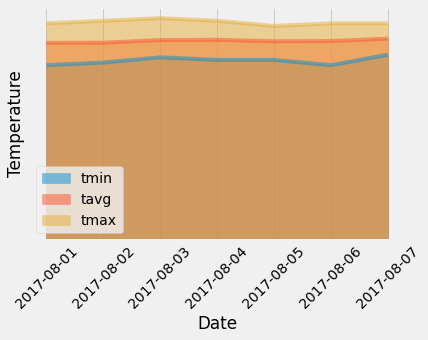

In [168]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(ylabel='Temperature', rot=45,stacked=False)
ax.set_yticks([])

plt.savefig('Images/DailyRainfallAverage.png', bbox_inches='tight',dpi = 150)

## Close Session

In [ ]:
# Close Session
session.close()